# Data Analysis 2 - Assignment 1



Pick an occupation and filter data accordingly.
You must choose different occupation(s) from what is covered in Ch09 (1005 + 1240). You may merge occupations as you see fit (eg. all tax/insurance specialists, etc.).
Tasks
• Show the unconditional gender gap.
• Show how the gender gap varies with the level of education. Consider several options to model the relationship.
• Interpret your key coefficients, including statistical inference.
• Summarize your findings.

In [45]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import plotly.express as px
from plotnine.data import mtcars
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")
pio.templates.default = 'plotly_white'

## 1 - DATA CLEANING

In [46]:
cps = pd.read_csv("morg-2014-emp.csv")

cps.columns

#### CLEANING TABLE
- Taking out "geo" data as we will not analyze geographical incidences ('stfips', 'state'), union-related data ('unionmme', 'unioncov'),questionnaire-handling data ('hhid', 'intmonth', 'weight', 'lfsr94') and 'ethnic' as low response.

In [47]:
del cps[cps.columns[0]]
cps.drop(columns = ["stfips", "state", "unionmme", "unioncov", "hhid", "intmonth", "weight", "ethnic", "lfsr94"], inplace = True)

In [50]:
cps.rename(columns = {
    'earnwke':'earn_wk',
    'uhours':'hours_wk',
    'grade92':'educ_level',
    'prcitshp':'native',
    'ind02':'industry'
}, inplace = True)

In [51]:
pd.options.display.float_format = "{:.1f}".format
cps.describe()

# TABLE 1

,earn_wk,hours_wk,educ_level,race,age,sex,marital,ownchild,chldpres,occ2012
count,149316.0,149316.0,149316.0,149316.0,149316.0,149316.0,149316.0,149316.0,149316.0,149316.0
mean,888.8,38.9,40.8,1.4,40.7,1.5,3.5,0.6,1.8,4161.2
std,643.7,10.3,2.5,1.3,12.8,0.5,2.7,1.0,3.1,2570.6
min,0.0,1.0,31.0,1.0,16.0,1.0,1.0,0.0,0.0,10.0
25%,430.0,40.0,39.0,1.0,30.0,1.0,1.0,0.0,0.0,2200.0
50%,719.6,40.0,40.0,1.0,41.0,1.0,1.0,0.0,0.0,4220.0
75%,1153.8,40.0,43.0,1.0,52.0,2.0,7.0,1.0,3.0,5700.0
max,2884.6,99.0,46.0,26.0,64.0,2.0,7.0,10.0,15.0,9750.0


### Comments: a few outliers on earning/week (eg over 100 respondants below $10 for over 30hrs of work).
We are in no position to analyze further, impact on the full database considered limited with over 149k observations. The data is kept as is.
_________________________________________________________________________________________________________________________

## 2 - DATA SELECTION
### Selecting occupation code from 4000 to 4160, ie "Food Preparation and Serving Related Occupations"

In [52]:
cps_occ = cps.loc[(cps["occ2012"] >=4000) & (cps["occ2012"] <=4160)]
cps_occ["occ2012"].value_counts()

4110    2178
4020    2147
4030     951
4010     608
4040     450
4000     444
4050     428
4130     416
4150     314
4140     289
4060     275
4120     194
Name: occ2012, dtype: int64

### This dataset represents about 5% of the database. Nearly half of the observations in 2 categories : 4110 (waiters and waitresses) and 4020 (cooks). Other categories are very close or often hybrids of these 2 main categories.
4000 Chefs and head cooks 35-1011  
4010 First-line supervisors/managers of food preparation and serving workers 35-1012  
4020 Cooks 35-2010  
4030 Food preparation workers 35-2021  
4040 Bartenders 35-3011  
4050 Combined food preparation and serving workers, including fast food 35-3021  
4060 Counter attendants, cafeteria, food concession, and coffee shop 35-3022  
4110 Waiters and waitresses 35-3031  
4120 Food servers, nonrestaurant 35-3041  
4130 Food preparation and serving related workers, all other including dining room and cafeteria attendants and bartender helpers 35-9011  
4140 Dishwashers 35-9021  
4150 Hosts and hostesses, restaurant, lounge, and coffee shop 35-9031
_________________________________________________________________________________________________________________________

#### Creating new variable "wage_hr" and checking quality of data (NA/NULL)

In [53]:
cps_occ["wage_hr"] = cps_occ["earn_wk"] / cps_occ["hours_wk"]
cps_occ.insert(loc=3, column='wage_hr', value=cps_occ.pop('wage_hr'))

In [54]:
cps_occ["wage_hr"].isnull().sum()

0

In [55]:
cps_occ["age"].isnull().sum()

0

In [56]:
cps_occ["sex"].isnull().sum()

0

In [57]:
cps_occ["educ_level"].isnull().sum()

0

In [58]:
cps_occ["sex"].value_counts()

2    4874
1    3820
Name: sex, dtype: int64

In [59]:
pd.options.display.float_format = "{:.2f}".format
cps_occ.describe()

,earn_wk,hours_wk,educ_level,wage_hr,race,age,sex,marital,ownchild,chldpres,occ2012
count,8694.00,8694.00,8694.00,8694.00,8694.00,8694.00,8694.00,8694.00,8694.00,8694.00,8694.00
mean,390.44,31.29,39.15,12.12,1.51,32.59,1.56,5.08,0.45,1.21,4061.88
std,298.21,11.37,2.28,7.85,1.51,13.26,0.50,2.61,0.90,2.67,48.18
min,0.73,1.00,31.00,0.01,1.00,16.00,1.00,1.00,0.00,0.00,4000.00
25%,200.00,21.00,39.00,8.11,1.00,21.00,1.00,1.00,0.00,0.00,4020.00
50%,328.25,35.00,39.00,10.00,1.00,29.00,2.00,7.00,0.00,0.00,4040.00
75%,480.00,40.00,40.00,13.85,1.00,43.00,2.00,7.00,1.00,1.00,4110.00
max,2884.61,99.00,46.00,276.92,24.00,64.00,2.00,7.00,7.00,15.00,4150.00


### From the summary table above, we see that:
 - the dataset accounts for 8694 observations.
 - it is more female than male (mean of sex at 1.56 - nearly 1000 more women).
 - a rather young population with 32 years on average (vs 40 for the total population).
 - child presence under the population average (possibly related to age).
 - lower hours per week (31hrs) than the average population (39hrs).
 - a lower wage per week (half that of the population) with similar standard deviation (in proportion).
 _____________________________________________________________________________________________________________________

In [60]:
cps_occ["educ_level"].value_counts()

39    3200
40    2197
43     765
37     617
36     371
42     355
41     241
35     238
38     218
33     171
34     141
44      72
32      69
31      26
45       7
46       6
Name: educ_level, dtype: int64

## 3 - INITIAL DATA ANALYSIS
##### Shows an unconditional bias of -10.4% on the wage per hour for women vs men ( USD 29.8 vs 33.2).

In [61]:
# Male population
cps_occ.loc[cps_occ.sex == 1, ["earn_wk", "hours_wk", "wage_hr", "age", "educ_level", "ownchild", "sex"]].describe()

# TABLE 2A

,earn_wk,hours_wk,wage_hr,age,educ_level,ownchild,sex
count,3820.00,3820.00,3820.00,3820.00,3820.00,3820.00,3820.00
mean,438.41,33.22,12.62,31.17,39.08,0.34,1.00
std,342.11,11.86,7.77,12.38,2.39,0.81,0.00
min,8.25,2.00,0.35,16.00,31.00,0.00,1.00
25%,224.00,25.00,8.33,21.00,39.00,0.00,1.00
50%,360.00,37.00,10.00,27.00,39.00,0.00,1.00
75%,542.65,40.00,14.40,39.00,40.00,0.00,1.00
max,2884.61,99.00,120.00,64.00,46.00,7.00,1.00


In [62]:
# Female population
cps_occ.loc[cps_occ.sex == 2,  ["earn_wk", "hours_wk", "wage_hr", "age", "educ_level", "ownchild", "sex"]].describe()

# TABLE 2B

,earn_wk,hours_wk,wage_hr,age,educ_level,ownchild,sex
count,4874.00,4874.00,4874.00,4874.00,4874.00,4874.00,4874.00
mean,352.84,29.78,11.72,33.71,39.21,0.54,2.00
std,252.39,10.73,7.90,13.81,2.19,0.96,0.00
min,0.73,1.00,0.01,16.00,31.00,0.00,2.00
25%,188.81,20.00,8.00,22.00,39.00,0.00,2.00
50%,300.00,30.00,10.00,30.00,39.00,0.00,2.00
75%,450.00,40.00,13.33,45.00,40.00,1.00,2.00
max,2884.61,84.00,276.92,64.00,46.00,7.00,2.00


### FINE-TUNING BY AGE GROUP:
#### Gap sarting after 25 years old and increasing until approx. 40 years old.

In [63]:
cps_occ1 = cps_occ.loc[cps_occ.sex == 1, ["earn_wk", "hours_wk", "wage_hr", "age", "educ_level", "ownchild"]]
cps_occ2 = cps_occ.loc[cps_occ.sex == 2, ["earn_wk", "hours_wk", "wage_hr", "age", "educ_level", "ownchild"]]

In [64]:
cps_comp1 = cps_occ1.groupby(["age"]).mean()
cps_comp2 = cps_occ2.groupby(["age"]).mean()
cps_comp = pd.merge(cps_comp1, cps_comp2, on = "age")
cps_comp = cps_comp.assign(Wage_diff = (cps_comp2["wage_hr"] / cps_comp1["wage_hr"])-1)
fig = px.bar(cps_comp, x = cps_comp.index, y = "Wage_diff", title = 'Wage/hr difference Female vs Male')
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

# GRAPH 1

#### To be noted also a gap in number of worked hours growing progressively up until the mid 40s, hence a much higher difference in total wage between men and women.

In [65]:
cps_comp = cps_comp.assign(Hours_diff = (cps_comp2["hours_wk"] / cps_comp1["hours_wk"])-1)
fig = px.bar(cps_comp, x = cps_comp.index, y = "Hours_diff", title = 'Hours-of-work difference Female vs Male')
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

# GRAPH 2

### FINE-TUNING BY EDUCATION LEVEL
31 	Less than 1st grade  
32 	1st - 4th grade  
33 	5th or 6th grade  
34 	7th or 8th grade  
35 	9th grade  
36 	10th grade  
37 	11th grade  
38 	12th grade NO DIPLOMA  
39 	High school graduate, diploma or GED  
40 	Some college but no degree  
41 	Associate degree -- occupational/vocational  
42 	Associate degree -- academic program  
43 	Bachelor's degree (e.g. BA,AB,BS)  
44 	Master's degree (e.g. MA,MS,MEng,Med,MSW,MBA)  
45 	Professional school deg. (e.g. MD,DDS,DVM,LLB,JD) 
46 	Doctorate degree (e.g. PhD, EdD)  

In [66]:
cps_comp1 = cps_occ1.groupby(["educ_level"]).mean()
cps_comp2 = cps_occ2.groupby(["educ_level"]).mean()
cps_comp = pd.merge(cps_comp1, cps_comp2, on = "educ_level")
cps_comp = cps_comp.assign(Wage_diff = (cps_comp2["wage_hr"] / cps_comp1["wage_hr"])-1)
fig = px.bar(cps_comp, x = cps_comp.index, y = "Wage_diff", title = 'Wage/hr difference Female vs Male')
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

# GRAPH 3

In [67]:
educ = []
for n in cps_occ["educ_level"]:
    if n < 39:
        educ.append('0')
    elif n > 40:
        educ.append('2')
    else:
        educ.append('1')
cps_occ['educ'] = educ
cps_edcat1 = cps_occ.loc[cps_occ.sex == 1, ["earn_wk", "hours_wk", "wage_hr", "age", "ownchild", "educ"]]
cps_edcat2 = cps_occ.loc[cps_occ.sex == 2, ["earn_wk", "hours_wk", "wage_hr", "age", "ownchild", "educ"]]
cps_edcat1 = cps_edcat1.groupby(["educ"]).mean()
cps_edcat2 = cps_edcat2.groupby(["educ"]).mean()
cps_edcat = pd.merge(cps_edcat1, cps_edcat2, on = "educ")
cps_edcat = cps_edcat.assign(Wage_diff = (cps_edcat.iloc[:,7] / cps_edcat.iloc[:,2])-1)
cps_edcat

# TABLE 3

,earn_wk_x,hours_wk_x,wage_hr_x,age_x,ownchild_x,earn_wk_y,hours_wk_y,wage_hr_y,age_y,ownchild_y,Wage_diff
educ,,,,,,,,,,,
0,294.65,28.81,9.86,28.64,0.45,256.42,26.40,9.62,30.05,0.55,-0.02
1,435.09,33.69,12.51,30.96,0.31,357.20,30.29,11.78,34.43,0.55,-0.06
2,648.33,37.63,16.84,35.41,0.31,451.97,31.84,14.05,35.31,0.48,-0.17


In [68]:
fig = px.bar(cps_edcat,
             x = cps_edcat.index,
             y = "Wage_diff", 
             title = 'Wage/hr difference by Catgory of Education<br>Women Vs Men -  0=no diploma  1=high school  2=graduate<br>',
             text_auto = True,
             labels = {"educ": "Education Level", "Wage_diff" : "Wage difference"}
            )
fig.layout.yaxis.tickformat = ',.0%'
fig.show()

# GRAPH 4

In [69]:
# DISTRIBUTION OF WAGE DATA BY GENDER
genders = ['male', 'female']
colors = ['blue','red']
distrib = ff.create_distplot(
    [cps_occ1["wage_hr"], cps_occ2["wage_hr"]],
    genders,
    bin_size = 0.5,
    curve_type = 'normal',
    colors = colors)
distrib.update_layout(title_text = 'Distribution of Wage per Hour - Comparison Feale vs Male<br><sup>50 cent bracket</sup>')
distrib.show()

# GRAPH 5A

#### OUTLIERS
We have some major outliers in wage/hr. In some instance, we observe high weekly salary over 2000 dollrs with low declared working hours (less than 10).
#### In the chart below, we limit the range to $50/hr to have a better view of the ditribution.

In [70]:
distrib.update_layout(xaxis = dict(range = [0,50]))
distrib.show()

# GRAPH 5B

In [71]:
# SPLITTING DATA FOR WOMEN AND MEN
cps_occ["lnWage"] = np.log(cps_occ["wage_hr"])
cps_occ['sex'] = cps_occ['sex'].astype(str)
cps_age = cps_occ.groupby(['sex','age']).mean()
count_age = cps_occ.groupby(['sex','age']).size().astype(int).rename('count')
cps_aged = pd.merge(count_age, cps_age, on = ['sex','age']).reset_index()

In [72]:
labelcsp = {
           'age' : 'Age',
           'wage_hr' : 'Wage per hour',
           'sex' : 'Gender',
           'educ_level':'Education level',
           'ownchild' : "Number of Children",
           'lnWage' : "Wage Variation (log)"
          }
scatter = px.scatter(cps_aged, x = 'age', y = 'wage_hr',
                     title = "Wage per hour Vs Age by Gender",
                     labels = labelcsp,
                     color = "sex",
                     symbol = "sex",
                     size = 'count',
                     trendline = 'ols'
                    )
chart_size = {'height' : 700, 'width' : 700}
scatter.update_layout(chart_size, title_x = 0.5)
scatter.update_traces(opacity = 0.9)

# GRAPH 6

In [73]:
# SIMILAR ANALYSIS ON EDUCATION LEVEL
cps_edu = cps_occ.groupby(['sex','educ_level']).mean()
count_edu = cps_occ.groupby(['sex','educ_level']).size().astype(int).rename('count')
cps_educ = pd.merge(count_edu, cps_edu, on = ['sex','educ_level']).reset_index()
cps_educ['educ_level'] = cps_educ['educ_level'].astype(str)

In [74]:
histo = px.histogram(
    cps_occ,
    x = 'educ_level',
    color = "sex",
    title = "Distribution of Education Level - Comparison Female (2) vs Male (1)",
    labels={'educ_level':'Education level','count':'Count'},
    color_discrete_sequence=px.colors.qualitative.Set1,
    barmode = 'group')
histo.show()

# GRAPH 7

In [75]:
# WAGE PER GENDER VS EDUCATION
scatter_edu = px.scatter(cps_educ, x = 'educ_level', y = 'wage_hr',
                         title = "Wage per hour Vs Education level",
                         labels = labelcsp,
                         color = 'sex',
                         symbol = 'sex',
                         color_discrete_map={"1": "Blue", "2": "Red"},
                         size = 'count',
                         trendline = 'ols',
                         template = 'simple_white'
)
chart_size = {'height' : 700, 'width' : 900}
scatter_edu.update_layout(chart_size, title_x = 0.5)
scatter_edu.update_traces(opacity = 0.9)

# GRAPH 8

In [76]:
# SAME WITH NUMBER OF CHILDREN
cps_kid = cps_occ.groupby(['sex','ownchild']).mean()
count_kid = cps_occ.groupby(['sex','ownchild']).size().astype(int).rename('count')
cps_kids = pd.merge(count_kid, cps_kid, on = ['sex','ownchild']).reset_index()

In [77]:
scatter_kid = px.scatter(cps_kids, x = 'ownchild', y = 'wage_hr',
                         title = "Wage per hour Vs Number of Children by Gender",
                         labels = labelcsp,
                         color = 'sex',
                         symbol = 'sex',
                         color_discrete_map={"1": "Blue", "2": "Red"},
                         size = 'count',
                         trendline = 'ols',
                         template = 'simple_white'
)
chart_size = {'height' : 700, 'width' : 900}
scatter_kid.update_layout(chart_size, title_x = 0.5)
scatter_kid.update_traces(opacity = 0.9)

# GRAPH 9

In [78]:
# LOG (WAGE) BY GENDER
scatterln = px.scatter(cps_aged, x = 'age', y = 'lnWage',
                       title = "Variation of Wage per hour Vs Age by Gender",
                       labels = labelcsp,
                       color = "sex",
                       symbol = "sex",
                       size = 'count',
                       trendline = 'ols'
                      )
chart_size = {'height' : 700, 'width' : 900}
scatterln.update_layout(chart_size, title_x = 0.5)
scatterln.update_traces(opacity = 0.9)

# GRAPH 10

## 4 - REGRESSION ANALYSIS

####  4.1 Gender differences in earnings

In [79]:
# Creating variables
cps_occ["female"] = (cps.sex == 2).astype(str)
cps_occ["male"] = (cps.sex == 1).astype(str)

In [80]:
# use robust std HC1
reg1 = smf.ols(formula="wage_hr ~ female", data = cps_occ).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                wage_hr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     28.36
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           1.03e-07
Time:                        04:18:59   Log-Likelihood:                -30240.
No. Observations:                8694   AIC:                         6.048e+04
Df Residuals:                    8692   BIC:                         6.050e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.6250      0.126    100.416      0.000      12.379      12.871
female[T.True]    -0.9007      0.169     -5.326      0.000      -1.232      -0.569
==============================================================================
Omnibus:                    12279.344   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11216802.414
Skew:                           7.868   Prob(JB):                         0.00
Kurtosis:                     178.262   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [81]:
reg2 = smf.ols(formula="lnWage ~ female", data = cps_occ).fit(cov_type="HC1")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     46.85
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           8.19e-12
Time:                        04:19:06   Log-Likelihood:                -6042.9
No. Observations:                8694   AIC:                         1.209e+04
Df Residuals:                    8692   BIC:                         1.210e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4125      0.008    312.213      0.000       2.397       2.428
female[T.True]    -0.0715      0.010     -6.845      0.000      -0.092      -0.051
==============================================================================
Omnibus:                     2189.872   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55199.207
Skew:                          -0.632   Prob(JB):                         0.00
Kurtosis:                      15.279   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

- The regression on Log(Wage) performs better than the regression on Wage on all parameters.

> Beta female: 
> in this sample, women are expected to earn 7.15 log points (7%) less than men, on average. This is much less of an impact than on the general population (19 log points).
> The p-value is close to 0 so we can reject the Null. Wages are dependent on gender.
> The SE is low at 0.01. The 95% CI interval gives a range from -5.1 to -9.2 (not including zero).  
> However R2 is low (0.005).


#### 4.2 Integration of the "age" variable

In [82]:
reg3 = smf.ols(formula="lnWage~female+age", data = cps_occ).fit(cov_type="HC1")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     235.5
Date:                Sun, 26 Nov 2023   Prob (F-statistic):          2.55e-100
Time:                        04:19:08   Log-Likelihood:                -5829.4
No. Observations:                8694   AIC:                         1.166e+04
Df Residuals:                    8691   BIC:                         1.169e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1618      0.013    161.122      0.000       2.136       2.188
female[T.True]    -0.0919      0.010     -8.921      0.000      -0.112      -0.072
age                0.0080      0.000     21.150      0.000       0.007       0.009
==============================================================================
Omnibus:                     2322.884   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65146.506
Skew:                          -0.677   Prob(JB):                         0.00
Kurtosis:                      16.342   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### IMPACT OF AGE

>- integrating the impact of age, women are expected to earn 9.2 log points less than men, on average. SE is low at 0.01. p close to zero.

>- the 95% CI on Beta ranges from -7.2 and -11.2 log points.

>- for each additional year of age, women are expected to earn 0.8 log pt more (almost 1%). This is a result online with the general population.

>- to be noted that up until the age of 25, women's wage per hour is slightly higher than for men, whilst differences in wage become strongly negative from 26 year-old and on.

>- unlike the general population, women in these professional categories are older than men (+2?6 year on average) with an unusual decrease in the men older population in the mid-40s.

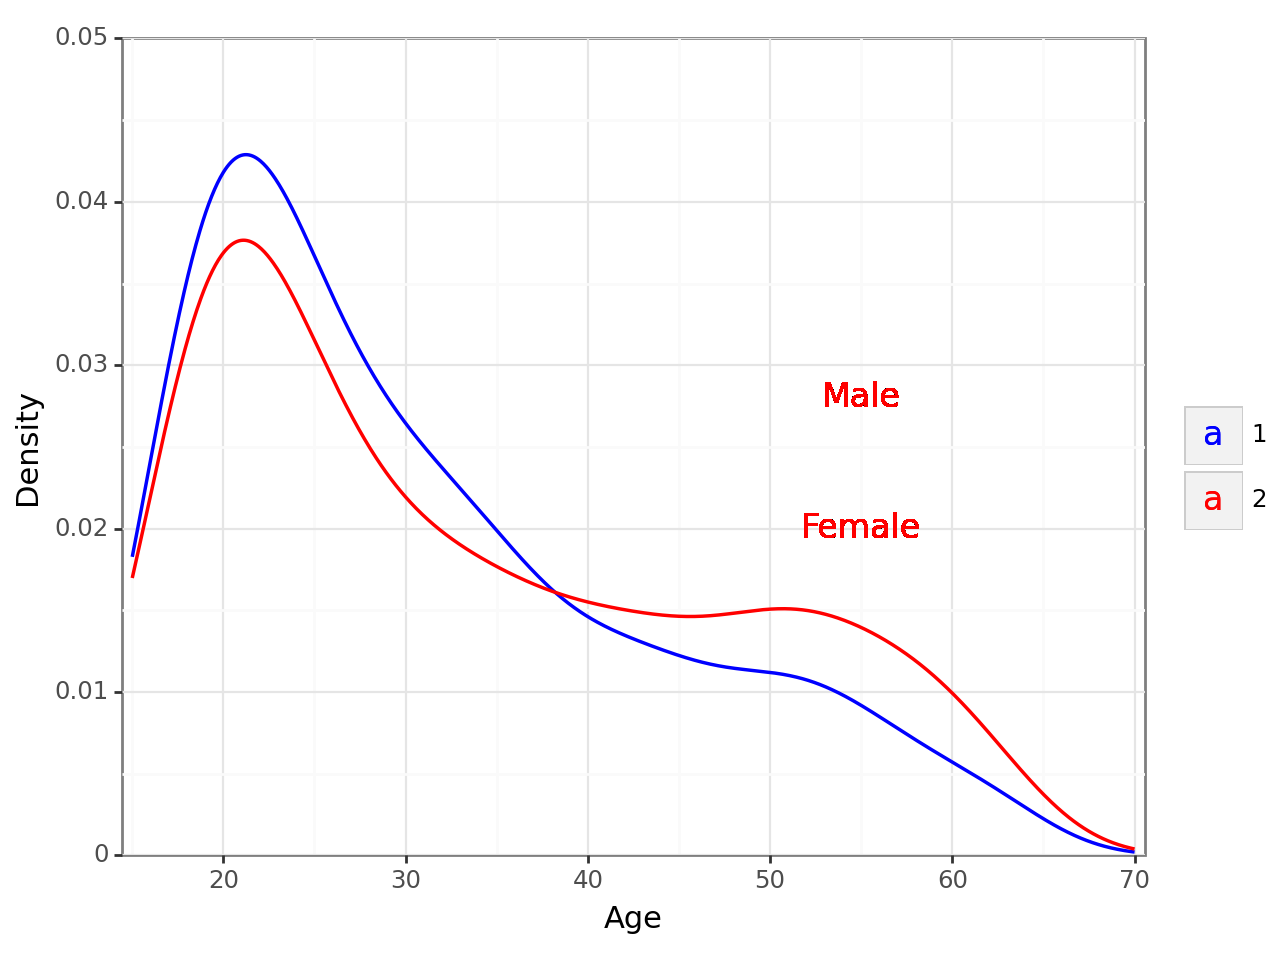

<Figure Size: (640 x 480)>

In [83]:
(ggplot(cps_occ, aes(x = "age", y = "stat(density)", color="sex"))
+ geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
+ labs(x="Age", y="Density", color="")
+ scale_x_continuous(expand=(0.01, 0.01), limits=(15, 70))
+ scale_y_continuous(expand=(0.0, 0.0), limits=(0, 0.05))
+ geom_text(aes(x=55, y=0.028, label="'Male'"), size=12)
+ geom_text(aes(x=55, y=0.020, label="'Female'"), size=12)
+ scale_color_manual(values=("blue", "red"))
+ theme_bw())

#### 4.3 How about the "education" variable ?

In [84]:
reg4 = smf.ols(formula="lnWage~female+educ_level", data = cps_occ).fit(cov_type="HC1") 
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     236.6
Date:                Sun, 26 Nov 2023   Prob (F-statistic):          9.21e-101
Time:                        04:19:31   Log-Likelihood:                -5830.4
No. Observations:                8694   AIC:                         1.167e+04
Df Residuals:                    8691   BIC:                         1.169e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5986      0.086      6.942      0.000       0.430       0.768
female[T.True]    -0.0774      0.010     -7.590      0.000      -0.097      -0.057
educ_level         0.0464      0.002     20.864      0.000       0.042       0.051
==============================================================================
Omnibus:                     2518.481   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67639.509
Skew:                          -0.803   Prob(JB):                         0.00
Kurtosis:                      16.570   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### IMPACT OF THE EDUCATION LEVEL

>- integrating impact of education, women are expected to earn 7.7 log points less than men, on average. 
>- the education ranking has no mathematical ground: each year of school gives an extra point to the education level up until high school.
>- hence the limited positive impact (0.46 log pt). With a scaling of 15 pts from the lowest to highest education level, education seems to have a limited incidence on wages.


#### 4.4 Simplifying the education equation with the education categories 0,1 & 2 (re. graph 4)

In [85]:
reg5 = smf.ols(formula="lnWage~female+educ", data = cps_occ).fit(cov_type="HC1") 
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     197.4
Date:                Sun, 26 Nov 2023   Prob (F-statistic):          7.97e-124
Time:                        04:19:31   Log-Likelihood:                -5767.7
No. Observations:                8694   AIC:                         1.154e+04
Df Residuals:                    8690   BIC:                         1.157e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2346      0.010    214.005      0.000       2.214       2.255
female[T.True]    -0.0770      0.010     -7.600      0.000      -0.097      -0.057
educ[T.1]          0.1864      0.012     16.197      0.000       0.164       0.209
educ[T.2]          0.3924      0.017     22.884      0.000       0.359       0.426
==============================================================================
Omnibus:                     2596.344   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73659.889
Skew:                          -0.830   Prob(JB):                         0.00
Kurtosis:                      17.163   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### IMPACT OF THE EDUCATION LEVEL (REVISITED)
>- a simple analysis by category of education (no diploma vs high school vs graduate) gives another view as illustrated by the initial bar chart and table where female graduates earned 46% more than women without any diploma (the gap is +70% for men). Female graduates earn 17% less than men graduates whilst the difference is only -2% in the population without diploma.
>- the new regression analysis gives a much better result with a much higher R2
>- impact of high school is 18 log pt (vs no diploma) and graduated is 39 log pt higher than no diploma.

#### 4.5 Looking deeper by segregating the people under 26 as we observe limited gender differences below that age group.

In [86]:
cps_26 = cps_occ.loc[(cps_occ["age"]) > 25]

In [87]:
reg6 = smf.ols(formula="lnWage~female+age", data = cps_26).fit(cov_type="HC1") 
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     56.12
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           7.80e-25
Time:                        04:19:31   Log-Likelihood:                -3396.1
No. Observations:                5105   AIC:                             6798.
Df Residuals:                    5102   BIC:                             6818.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4711      0.025     98.328      0.000       2.422       2.520
female[T.True]    -0.1439      0.014    -10.543      0.000      -0.171      -0.117
age                0.0020      0.001      3.318      0.001       0.001       0.003
==============================================================================
Omnibus:                     1007.427   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18584.612
Skew:                          -0.431   Prob(JB):                         0.00
Kurtosis:                      12.307   Cond. No.                         169.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### 4.6 Adding education, age and children is what gives the better R2 at 0.08 and a slightly narrower CI.

In [88]:
reg7 = smf.ols(formula="lnWage~female+educ+age+ownchild", data = cps_26).fit(cov_type="HC1") 
reg7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     89.46
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           1.76e-90
Time:                        04:19:31   Log-Likelihood:                -3242.6
No. Observations:                5105   AIC:                             6497.
Df Residuals:                    5099   BIC:                             6536.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2770      0.030     77.157      0.000       2.219       2.335
female[T.True]    -0.1398      0.013    -10.434      0.000      -0.166      -0.114
educ[T.1]          0.1711      0.015     11.079      0.000       0.141       0.201
educ[T.2]          0.3608      0.020     17.828      0.000       0.321       0.401
age                0.0024      0.001      3.973      0.000       0.001       0.004
ownchild          -0.0109      0.006     -1.732      0.083      -0.023       0.001
==============================================================================
Omnibus:                     1158.792   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22014.923
Skew:                          -0.589   Prob(JB):                         0.00
Kurtosis:                      13.105   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [89]:
reg8 = smf.ols(formula="lnWage~female+educ", data = cps_26).fit(cov_type="HC1") 
reg8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnWage   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     141.1
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           7.85e-88
Time:                        04:19:31   Log-Likelihood:                -3254.3
No. Observations:                5105   AIC:                             6517.
Df Residuals:                    5101   BIC:                             6543.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3649      0.014    163.982      0.000       2.337       2.393
female[T.True]    -0.1352      0.013    -10.406      0.000      -0.161      -0.110
educ[T.1]          0.1731      0.015     11.348      0.000       0.143       0.203
educ[T.2]          0.3603      0.020     18.080      0.000       0.321       0.399
==============================================================================
Omnibus:                     1151.606   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21749.105
Skew:                          -0.583   Prob(JB):                         0.00
Kurtosis:                      13.044   Cond. No.                         6.11
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### FOR SIMPLICITY WE CAN GIVE A PREFERENCE TO GENDER + EDUCATION TO EXPLAIN DIFFERENCES

>- Integrating the impact of just these two variables on women aged 26+, female workers are expected to earn 13.5 log points less than men on average due to gender, with a 95%CI at +/- 2.5pts.
>- High school brings a 17% differnce and graduation a 36%.
>- with the p test we can reject the null hypothesis.

#### FOR BETTER INTEGRATION OF ALL PARAMETERS: GENDER + AGE + OWNCHILD + EDUCATION

>- These are the best regression results with higher R2, best T test, lowest std deviation
>- Interest of this option is to materialize the fact that something happens to women after 25 years of age and again in the mid 40s (where they outnumber men as age increases, an unusual characteritic attached to these job categories). To that extent, "marital" has a similar impact than "ownchild".

## 5 - CONCLUSIONS

>- Unconditional bias, significant but lower than the general population.
>- No inference: correlation remains too low, multiple results depending on selected variables, many fluctuations remain unexplained.
>- This analysis demonstrates the complexity of the subject with so many variables impacting wages: gender, age, education, children,...
>- The "Food Preparation and Serving Related" sector shows it has its own rules, notably on working hours and career perspectives, and definitely so on female/male worker characteristics very specific to that sector.
>- No causality demonstrated.
>- No predictability with any model.